In [1]:
####This notebook required run on  parallel algorithms which base on MPI####
import  numpy  as  np
import libpysal as ps
from stwr.gwr import GWR, MGWR,STWR
from stwr.sel_bw import *
from stwr.utils import shift_colormap, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
import pandas as pd
import math
from matplotlib.gridspec import GridSpec
import time
import csv 
import copy 

In [2]:
import rasterio
import rasterio.plot
import rasterio.features
import rasterio.warp
import pyproj

In [3]:
#读入数据需要有这些
cal_coords_list =[]
cal_y_list =[]
cal_X_list =[]
delt_stwr_intervel =[0.0]
csvFile = open("D:/STWR/Code_release/stwr/STWR/Data_STWR/RealWorldData/precip_isotope_D3.csv", "r")
df = pd.read_csv(csvFile,header = 0,names=['Longitude','Latitude','Elevation','ppt','tmean','d2h','timestamp'],
                 dtype = {"Longitude" : "float64","Latitude":"float64",
                          "Elevation":"float64","ppt":"float64","tmean":"float64","d2h":"float64",
                          "timestamp":"float64"},
                 skip_blank_lines = True,
                 keep_default_na = False)
df.info()
df = df.sort_values(by=['timestamp'])  
all_data = df.values
tick_time = all_data[0,-1]
cal_coord_tick = []
cal_X_tick =[]
cal_y_tick =[]
time_tol = 1.0e-7

lensdata = len(all_data)
for row in range(lensdata):
    cur_time = all_data[row,-1]
    if(abs(cur_time-tick_time)>time_tol):
        cal_coords_list.append(np.asarray(cal_coord_tick))
        cal_X_list.append(np.asarray(cal_X_tick))
        cal_y_list.append(np.asarray(cal_y_tick))
        delt_t = cur_time - tick_time
        delt_stwr_intervel.append(delt_t) 
        tick_time =cur_time
        cal_coord_tick = []
        cal_X_tick =[]
        cal_y_tick =[]
    coords_tick = np.array([all_data[row,0],all_data[row,1]])
    cal_coord_tick.append(coords_tick)

    x_tick = np.array([all_data[row,2],all_data[row,3],all_data[row,4]])
    cal_X_tick.append(x_tick)
    y_tick = np.array([all_data[row,5]])
    cal_y_tick.append(y_tick)
#最后在放一次
#gwr解出最后一期 
cal_cord_gwr = np.asarray(cal_coord_tick)
cal_X_gwr  = np.asarray(cal_X_tick)
cal_y_gwr = np.asarray(cal_y_tick)  
cal_coords_list.append(np.asarray(cal_coord_tick))
cal_X_list.append(np.asarray(cal_X_tick))
cal_y_list.append(np.asarray(cal_y_tick))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  272 non-null    float64
 1   Latitude   272 non-null    float64
 2   Elevation  272 non-null    float64
 3   ppt        272 non-null    float64
 4   tmean      272 non-null    float64
 5   d2h        272 non-null    float64
 6   timestamp  272 non-null    float64
dtypes: float64(7)
memory usage: 15.0 KB


In [4]:
#stwr 
stwr_selector_ = Sel_Spt_BW(cal_coords_list, cal_y_list, cal_X_list,#gwr_bw0,
                            delt_stwr_intervel,spherical = True)
#(1)Here we use parallel algorithms.
optalpha,optsita,opt_btticks,opt_gwr_bw0 = stwr_selector_.search(nproc = 12) 
stwr_model = STWR(cal_coords_list,cal_y_list,cal_X_list,delt_stwr_intervel,
                  optsita,opt_gwr_bw0,tick_nums=opt_btticks,alpha =optalpha,spherical = True,recorded=1)
#(2)We use oridinary algorithms
#optalpha,optsita,opt_btticks,opt_gwr_bw0 = stwr_selector_.search() 
#stwr_model = STWR(cal_coords_list,cal_y_list,cal_X_list,delt_stwr_intervel,optsita,opt_gwr_bw0,tick_nums=opt_btticks+1,alpha =optalpha,spherical = True,recorded=1)

In [5]:
stwr_results = stwr_model.fit()
print(stwr_results.summary())
stwr_scale = stwr_results.scale 
stwr_residuals = stwr_results.resid_response

Model type                                                         Gaussian
Number of observations:                                                 182
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          52669.399
Log-likelihood:                                                    -343.801
AIC:                                                                695.602
AICc:                                                               698.498
BIC:                                                              52373.357
R2:                                                                   0.502
Adj. R2:                                                              0.481

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [6]:
#gwr  数据只有最后一期
gwr_selector = Sel_BW(cal_cord_gwr, cal_y_gwr, cal_X_gwr,spherical = True)
gwr_bw= gwr_selector.search(bw_min=2)
gwr_model = GWR(cal_cord_gwr, cal_y_gwr, cal_X_gwr, gwr_bw,spherical = True)
gwr_results = gwr_model.fit()
print(gwr_results.summary())
gw_rscale = gwr_results.scale 
gwr_residuals = gwr_results.resid_response

Model type                                                         Gaussian
Number of observations:                                                  73
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          52669.399
Log-likelihood:                                                    -343.801
AIC:                                                                695.602
AICc:                                                               698.498
BIC:                                                              52373.357
R2:                                                                   0.502
Adj. R2:                                                              0.481

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [7]:
#预测面
Pred_Coords_list =[]
X_pre_list = []
theight1 = rasterio.open('D:/STWR/Code_release/stwr/STWR/Data_STWR/RealWorldData/extgmted1.tif')
bheight1 = theight1.read(1)
ppt1 = rasterio.open('D:/STWR/Code_release/stwr/STWR/Data_STWR/RealWorldData/extppt1.tif') 
bppt1 = ppt1.read(1)
mean1 = rasterio.open('D:/STWR/Code_release/stwr/STWR/Data_STWR/RealWorldData/extmean1.tif') 
bmean1 = mean1.read(1)

In [8]:
pf = ppt1.profile
transform =ppt1.profile['transform']
nodata = pf['nodata']

In [9]:
#nodata
#transform 
Z =  bppt1.copy()
#Z = Z.astype(np.float64)
Z2 = bppt1.copy()
#Z2 = Z2.astype(np.float64)

In [10]:
mask_height = ppt1.dataset_mask()
for row in range(mask_height.shape[0]):
    for col in range (mask_height.shape[1]):
        if(mask_height[row,col]>0):
            X_tick = np.array([bheight1[row,col],bppt1[row,col],bmean1[row,col]])
            X_pre_list.append(X_tick)
            Pred_Coords_list.append(ppt1.xy(row,col))
 
X_pre_arr = np.asarray(X_pre_list)
alllen_stwr = len(Pred_Coords_list)
allklen_stwr = X_pre_arr.shape[1]+1
rec_parmas_stwr = np.ones((alllen_stwr,allklen_stwr))
calen_stwr =  len(cal_y_list[-1])
prelen_stwr = X_pre_arr.shape[0]
Pre_y_list = np.ones_like(X_pre_arr[:,1])
#gwr
Pre_gwr_y_list = Pre_y_list.copy()
#gwr
stwr_pre_parmas = np.ones((prelen_stwr,allklen_stwr))
if (calen_stwr>=prelen_stwr):
       predPointList = Pred_Coords_list
       PreX_list = X_pre_arr
       #stwr
       pred_stwr_dir_result = stwr_model.predict(predPointList,PreX_list,stwr_scale,stwr_residuals)
       pre_y_stwr = pred_stwr_dir_result.predictions 
       #gwr
       pred_gwr_dir_result = gwr_model.predict(predPointList,PreX_list,gw_rscale,gwr_residuals)
       pre_y_gwr = pred_gwr_dir_result.predictions
       #gwr
else:
        spl_parts_stwr = math.ceil(prelen_stwr*1.0/calen_stwr) 
        spl_X_stwr = np.array_split(X_pre_arr, spl_parts_stwr, axis = 0)
        spl_coords_stwr = np.array_split(Pred_Coords_list, spl_parts_stwr, axis = 0)
        pred_stwr_result = np.array_split(Pre_y_list, spl_parts_stwr, axis = 0)
#        pred_stwrparmas_result = np.array_split(stwr_pre_parmas, spl_parts_stwr, axis = 0)
        #gwr
        pred_gwr_result = np.array_split(Pre_gwr_y_list, spl_parts_stwr, axis = 0)
        #gwr
        for j in range(spl_parts_stwr):
                predPointList_tick = [spl_coords_stwr[j]]
                PreX_list_tick = [spl_X_stwr[j]]
                pred_stwr_spl_result =  stwr_model.predict(predPointList_tick,PreX_list_tick,stwr_scale,stwr_residuals)
                pred_stwr_result[j] =pred_stwr_spl_result.predictions 
#                pred_stwrparmas_result[j] =np.reshape(pred_stwr_spl_result.params.flatten(),(-1,allklen_stwr))
                #gwr
                pred_gwr_spl_result =  gwr_model.predict(spl_coords_stwr[j],spl_X_stwr[j],gw_rscale,gwr_residuals)
                pred_gwr_result[j] =pred_gwr_spl_result.predictions
                #gwr
        pre_y_stwr = pred_stwr_result[0]
#        pre_parmas_stwr = pred_stwrparmas_result[0]
        combnum = spl_parts_stwr-1
        #gwr
        pre_y_gwr=pred_gwr_result[0]
        #gwr
        for s in range(combnum):
            pre_y_stwr = np.vstack((pre_y_stwr,pred_stwr_result[s+1]))
#            pre_parmas_stwr = np.vstack((pre_parmas_stwr,pred_stwrparmas_result[s+1]))
            #gwr
            pre_y_gwr = np.vstack((pre_y_gwr,pred_gwr_result[s+1]))
            #gwr

In [11]:
idx = 0  
mask_ppt = ppt1.dataset_mask()

for row in range(mask_ppt.shape[0]):
    for col in range (mask_ppt.shape[1]):
        if(mask_height[row,col]>0):
                Z[row,col] = pre_y_stwr[idx]
                #gwr
                Z2[row,col] = pre_y_gwr[idx]
                #gwr
                idx = idx+1
#                idx_stwr.iternext()
#                idx_gwr.iternext()
#idx = 0               
#mask_height = theight1.dataset_mask()
#for row in range(mask_height.shape[0]):
#    for col in range (mask_height.shape[1]):
#        if(mask_height[row,col]>0):
#                Z[row,col] = pre_y_stwr[idx,-1]
#                #gwr
#                Z2[row,col] = pre_y_gwr[idx,-1]
#                #gwr
#                idx=idx+1

with rasterio.open('D:/STWR/Code_release/stwr/STWR/Data_STWR/RealWorldData/Rst3_fstwr_r.tif', 'w', driver='GTiff', 
                   height=Z.shape[0],
                   width=Z.shape[1], count=1, dtype=Z.dtype,
                   crs='+proj=latlong', transform=transform,nodata = nodata) as dststwr:
    dststwr.write(Z, 1)

with rasterio.open('D:/STWR/Code_release/stwr/STWR/Data_STWR/RealWorldData/Rst3_fstwr_r.tif', 'w', driver='GTiff', 
                   height=Z2.shape[0],
                   width=Z2.shape[1], count=1, dtype=Z2.dtype,
                   crs='+proj=latlong', transform=transform,nodata = nodata) as dstgwr:
    dstgwr.write(Z2, 1)  

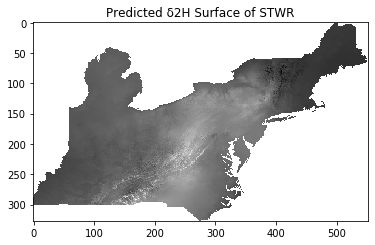

In [12]:
pyplot.title("Predicted δ2H Surface of STWR")
pyplot.imshow(Z,cmap='binary',vmin=-238.478, vmax=18.4553)
pyplot.show()

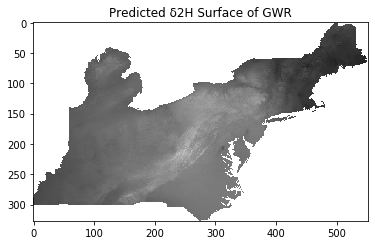

In [13]:
pyplot.title("Predicted δ2H Surface of GWR")
pyplot.imshow(Z2, cmap='binary',vmin=-238.478, vmax=18.4553)
pyplot.show()